In [1]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np

pd.set_option('mode.chained_assignment',  None) # 경고 off

In [23]:
data  = pd.read_csv('./raw_data.csv', index_col = 0, encoding='CP949')
cols = list(data.columns)
cols.reverse()

mean_col = [f'{i}_mean_acc' for i in cols]
mean_data = pd.DataFrame(columns=mean_col)

am_col = [f'{i}_AM' for i in cols]
am_data = pd.DataFrame(columns=am_col)

rm_col = [f'{i}_RM' for i in cols]
rm_data = pd.DataFrame(columns=rm_col)

del mean_data['close_mean_acc']
#del rm_data['close_RM']


for i in cols:
    print(i)
    # 누적 수익률
    df_PROFIT = data[i].pct_change()
    data[f'{i}_acc'] = (1+df_PROFIT).cumprod()-1

    # log 누적 수익률
    df_LOG_PROFIT = np.log(df_PROFIT+1)
    data[f'{i}_log_acc'] = df_LOG_PROFIT.cumsum()
    data.fillna(0,inplace=True)

    # 필요없는 부분 except 처리
    try:
        data = pd.concat([data, mean_data[f'{i}_mean_acc']],axis=1)
    except:
        pass
    finally:
        data = pd.concat([data, am_data[f'{i}_AM']],axis=1)
        data = pd.concat([data, rm_data[f'{i}_RM']],axis=1)

    # 평균 누적 수익률

    for j in range(0, len(data)):   
        try:
            data[f'{i}_mean_acc'][j] = (data[f'{i}_acc'][j] - data['close_acc'][j])
        except:
            pass
        
        if j == 0:
            continue
        else:
            # 절대 모멘텀
            data[f'{i}_AM'][j] = ((data[i][j] / data[i][j-1]) - 1)
            
            if i == 'close':
                pass
            else:
                # 상대 모멘텀
                data[f'{i}_RM'][j] = (data[f'{i}_AM'][j] - data['close_AM'][j])

    data.fillna(0,inplace=True)

#col_name = ['A293490','A263750','A259960','A251270','A194480','A192080','A181710','A112040','A078340','A036570']
index_date = list(data.index)
book = pd.DataFrame(columns=cols, index=index_date)
book

for col in cols:
    for i in range(0, len(data)):
        if data[f'{col}_AM'][i] > 0 and data[f'{col}_RM'][i] > 0:
            book[col][i] = 1
            
        else:
            book[col][i] = 0

# Signal
for col in cols:
    #buy_idx = book[col][book[col] == 1][0::2].index
    sell_idx = book[col][book[col] == 1][1::2].index
    for sell in sell_idx:
        book[col].loc[sell] = -1
    
# 항목별 리스트 분리
new_cols = list(data.columns)
new_cols
log_acc =[]
for x in new_cols: 
    if "log_acc" in x:
       log_acc.append(x)

acc =[]
for x in new_cols: 
    if "acc" in x:
       acc.append(x)

       
mean_acc =[]
for x in new_cols: 
    if "mean_acc" in x:
       mean_acc.append(x)
    


close
A293490_카카오게임즈
A263750_펄어비스
A259960_크래프톤
A251270_넷마블
A194480_데브시스터즈
A192080_더블유게임즈
A181710_NHN
A112040_위메이드
A078340_컴투스
A036570_엔씨소프트


In [56]:
# 차트

import plotly.graph_objects as go
import numpy as np

columns = log_acc

fig = go.Figure()
for i in range(0,len(columns)):
    fig.add_scatter(name=columns[i])


for i in range(0,len(columns)):
    fig.data[i].x = data.index
    fig.data[i].y = data[columns[i]]

fig.data[0].line.color = 'black'
fig.data[0].line.width = 4
fig.data[0].line.dash = 'dash'
fig.update_layout(
    autosize=True,
    width=1800,
    height=1000
    )
fig

In [39]:
import plotly.graph_objects as go
import numpy as np


# labels = ['D_RTN_A259960','D_RTN_A036570','D_RTN_A251270','D_RTN_A293490','D_RTN_A263750','D_RTN_A078340','D_RTN_A181710','D_RTN_A192080','D_RTN_A194480','D_RTN_A112040',
#     'sma5','sma20','sma100','sma200']

#cols = ['A293490','A263750','A259960','A251270','A194480','A192080','A181710','A112040','A078340','A036570']

columns = log_acc

fig = go.Figure()
for i in range(0,len(columns)):
    fig.add_scatter(name=columns[i])


for i in range(0,len(columns)):
    fig.data[i].x = data.index
    fig.data[i].y = data[columns[i]]

fig



In [95]:
#
# Python Script with Base Class
# for Event-Based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'


class BacktestBase(object):
    ''' 거래 전략을 가지고 이벤트 기반 백테스트를 하기 위한 기저 클래스
    속성
    ==========
    symbol: str
        사용할 TR RIC (금융 수단)
    start: str
        데이터를 선택한 부분의 시작 일자
    end: str
        데이터를 선택한 부분의 종료 일자
    amount: float
        한 번 투자하거나 거래당 투자할 금액
    ftc: float
        거래당 고정 거래비용(매수 또는 매도)
    ptc: float
        거래당 비례 거래비용(매수 또는 매도)
    
    메소드
    =======
    get_data:
        기본 데이터 집합을 검색해(인출해) 준비한다.
    plot_data:
        종목코드에 대한 종가를 그려 낸다.
    get_date_price:
        주어진 봉에 대한 일자와 가격을 반환한다.
    print_balance:
        현재 (현금) 잔고를 프린트해 낸다.
    print_net_wealth:
        현재 순 자산을 프린트해 낸다.
    place_buy_order:
        매수 주문을 넣는다.
    place_sell_order:
        매도 주문을 넣는다.
    close_out:
        롱 포지션이나 숏 포지션을 닫는다.
    '''

    def __init__(self, amount,
                verbose=True):
        #self.symbol = symbol
        #self.start = start
        #self.end = end
        self.initial_amount = amount
        self.amount = amount
        #self.ftc = ftc
        #self.ptc = ptc
        self.units = 0
        self.position = 0
        self.trades = 0
        self.verbose = verbose
        self.get_data()

    def get_data(self):
        ''' 데이터를 검색해(인출해) 준비해둔다.
        '''
        data = pd.read_csv('./raw_data.csv', index_col = 0, encoding='CP949')
        col = list(data.columns)
        col.reverse()

        mean_col = [f'{i}_mean_acc' for i in col]
        mean_data = pd.DataFrame(columns=mean_col)

        am_col = [f'{i}_AM' for i in col]
        am_data = pd.DataFrame(columns=am_col)

        rm_col = [f'{i}_RM' for i in col]
        rm_data = pd.DataFrame(columns=rm_col)

        del mean_data['close_mean_acc']

        for i in col:
            print(i)
            # 누적 수익률
            df_PROFIT = data[i].pct_change()
            data[f'{i}_acc'] = (1+df_PROFIT).cumprod()-1

            # log 누적 수익률
            df_LOG_PROFIT = np.log(df_PROFIT+1)
            data[f'{i}_log_acc'] = df_LOG_PROFIT.cumsum()
            data.fillna(0,inplace=True)

            # 필요없는 부분 except 처리
            try:
                data = pd.concat([data, mean_data[f'{i}_mean_acc']],axis=1)
            except:
                pass
            finally:
                data = pd.concat([data, am_data[f'{i}_AM']],axis=1)
                data = pd.concat([data, rm_data[f'{i}_RM']],axis=1)

            # 평균 누적 수익률

            for j in range(0, len(data)):   
                try:
                    data[f'{i}_mean_acc'][j] = (data[f'{i}_acc'][j] - data['close_acc'][j])
                except:
                    pass
                
                if j == 0:
                    continue
                else:
                    # 절대 모멘텀
                    data[f'{i}_AM'][j] = ((data[i][j] / data[i][j-1]) - 1)
                    
                    if i == 'close':
                        pass
                    else:
                        # 상대 모멘텀
                        data[f'{i}_RM'][j] = (data[f'{i}_AM'][j] - data['close_AM'][j])

            data.fillna(0,inplace=True)
        col_name = data.columns[0:11]
        data = data[col_name]
        self.data = data

    def plot_data(self, cols=None):
        ''' 종목코드의 종가를 표시한다.
        '''
        if cols is None:
            cols = ['price']
        self.data[cols].plot(figsize=(10, 6), title=self.symbol)

    def get_date_price(self, bar, col):
        ''' 봉에 대한 일자와 가격을 반환한다.
        '''
        date = str(self.data.index[bar])[:10]
        price = self.data.col.iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' 현재 현금잔고 정보를 프린트한다.
        '''
        date, price = self.get_date_price(bar, col)
        print(f'{date} | current balance {self.amount:.2f}')

    def print_net_wealth(self, bar, col):
        ''' 현재 현금잔고 정보를 프린트한다.
        '''
        date, price = self.get_date_price(bar, col)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, col, units=None, amount=None):
        ''' 매수 주문을 넣는다.
        '''
        date, price = self.get_date_price(bar, col)
        if units is None:
            units = int(amount / price)
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def place_sell_order(self, bar, col, units=None, amount=None):
        ''' 매도 주문을 넣는다.
        '''
        date, price = self.get_date_price(bar, col)
        if units is None:
            units = int(amount / price)
        self.amount += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def close_out(self, bar, col):
        ''' 롱 포지션이나 숏 포지션을 닫는다.
        '''
        date, price = self.get_date_price(bar, col)
        self.amount += self.units * price
        self.units = 0
        self.trades += 1
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
        print('Final balance   [$] {:.2f}'.format(self.amount))
        perf = ((self.amount - self.initial_amount) /
                self.initial_amount * 100)
        print('Net Performance [%] {:.2f}'.format(perf))
        print('Trades Executed [#] {}'.format(self.trades))
        print('=' * 55)


if __name__ == '__main__':
    #col = ['A293490','A263750','A259960','A251270','A194480','A192080','A181710','A112040','A078340','A036570']
    bb = BacktestBase(10000000)
    #print(bb.data.info())
    #print(bb.data.tail())
    #bb.plot_data()
    #plt.savefig('../../images/ch06/backtestbaseplot.png')

close
A293490_카카오게임즈
A263750_펄어비스
A259960_크래프톤
A251270_넷마블
A194480_데브시스터즈
A192080_더블유게임즈
A181710_NHN
A112040_위메이드
A078340_컴투스
A036570_엔씨소프트


In [1]:
#
# Python Script with Long Short Class
# for Event-Based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
from BacktestBase import *
pd.set_option('mode.chained_assignment',  None)


class BacktestLongShort(BacktestBase):

    def go_buy(self, bar, col, units=None, amount=None):
        if self.position == -0:
            amount = self.amount
            self.place_buy_order(bar, col, units=-self.units, amount=amount)
            print('buy 1 unit :', self.units)
        if self.position == -1:
            amount = self.amount
            self.place_buy_order(bar, col, units=-self.units, amount=amount)
            print('buy 1 unit :', self.units)

    def go_sell(self, bar, col, units=None, amount=None):
        if self.position == 1:
            amount = self.amount
            self.place_sell_order(bar, col, units=self.units, amount=amount)
            print('sell 1 unit :', self.units)

    def run_momentum_strategy(self):
        msg = f'\n\nRunning momentum strategy'
        #msg += f'\nfixed costs {self.ftc} | '
        #msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # 초기 뉴트럴 포지션
        self.trades = 0  # 아직 거래 없음
        self.amount = self.initial_amount  # 초기 자본 재설정
        self.cols = self.data.columns[0:10]
        self.all_cols = self.data

        self.am = []
        for x in self.all_cols: 
            if "AM" in x:
                self.am.append(x)

        self.rm = []
        for x in self.all_cols: 
            if "RM" in x:
                self.rm.append(x)

        for col in self.cols:
            print(col)
            print( '=' * 55 )
            # 종목별 초기화
            self.trades = 0
            self.amount = self.initial_amount
            for i in range(0, len(self.data)):
                print('직전 포지션 : ', self.position)
                if self.position in [0, -1]:
                    if self.data[f'{col}_AM'][i] > 0 and self.data[f'{col}_RM'][i] > 0:
                        self.go_buy(i, col)
                        self.position = 1  # 매수 포지션
                        print('상태 : buy')
                    else:
                        print('상태 : 포지션 유지')
                        pass
                elif self.position in [0, 1]:
                    if not self.data[f'{col}_AM'][i] > 0 or self.data[f'{col}_RM'][i] > 0:
                        self.go_sell(i, col)
                        self.position = -1  # 매도 포지션
                        print('상태 : sell')
                    else:
                        print('상태 : 포지션 유지')
                        pass
                print(f'종목 : {col} | index : {i} | 날짜 : {self.data[col].index[i]} | 포지션 : {self.position} | 종가 : {self.data[col][i]} | 수량 : {self.units} | 잔고 : {self.amount} | 거래 : {self.trades}')
                print("="*50)
            self.close_out(i, col)

if __name__ == '__main__':
    def run_strategies():
        #lsbt.run_sma_strategy(42, 252)
        lsbt.run_momentum_strategy()
        #lsbt.run_mean_reversion_strategy(50, 5)
    lsbt = BacktestLongShort(10000000,
                             verbose=False)
    run_strategies()
    # # 거래 비용 : 10달러 고정, 1% 변동
    # lsbt = BacktestLongShort('AAPL.O', '2010-1-1', '2019-12-31',
    #                          10000, 10.0, 0.01, False)
    # run_strategies()



Running momentum strategy
A036570_엔씨소프트
직전 포지션 :  0
상태 : 포지션 유지
종목 : A036570_엔씨소프트 | index : 0 | 날짜 : 2021-08-10 | 포지션 : 0 | 종가 : 815000 | 수량 : 0 | 잔고 : 10000000 | 거래 : 0
직전 포지션 :  0
상태 : 포지션 유지
종목 : A036570_엔씨소프트 | index : 1 | 날짜 : 2021-08-11 | 포지션 : 0 | 종가 : 790000 | 수량 : 0 | 잔고 : 10000000 | 거래 : 0
직전 포지션 :  0
units :  0 / amount :  10000000
<매수> 잔고 : 328000 | 매수 금액 : 9672000 | 잔여 수량 : 12 | 수량 : 12 | trades : 1
buy 1 unit : 12
상태 : buy
종목 : A036570_엔씨소프트 | index : 2 | 날짜 : 2021-08-12 | 포지션 : 1 | 종가 : 806000 | 수량 : 12 | 잔고 : 328000 | 거래 : 1
직전 포지션 :  1
units :  12 / amount :  328000
<매도> 잔고 : 9760000 | 매도 금액 : 9432000 | 잔여 수량 : 0 | 수량 : 12 | trades : 2
sell 1 unit : 0
상태 : sell
종목 : A036570_엔씨소프트 | index : 3 | 날짜 : 2021-08-13 | 포지션 : -1 | 종가 : 786000 | 수량 : 0 | 잔고 : 9760000 | 거래 : 2
직전 포지션 :  -1
상태 : 포지션 유지
종목 : A036570_엔씨소프트 | index : 4 | 날짜 : 2021-08-17 | 포지션 : -1 | 종가 : 771000 | 수량 : 0 | 잔고 : 9760000 | 거래 : 2
직전 포지션 :  -1
units :  0 / amount :  9760000
<매수> 잔고 : 304000 | 매수 금액 : 

In [6]:
import os
currentPath = os.getcwd()
print(currentPath)
files = os.listdir(currentPath)
print(files)

/workspaces/Americano/americano/engine/test_stg_ash
['A036570.csv', 'A078340.csv', 'A112040.csv', 'A181710.csv', 'A192080.csv', 'A194480.csv', 'A244580.csv', 'A251270.csv', 'A259960.csv', 'A263750.csv', 'A293490.csv', 'aa.py', 'aaa.csv', 'ash_strategy.ipynb', 'BacktestBase copy.py', 'BacktestBase.py', 'BacktestLongShort.py', 'data_1136_20220818.csv', 'data_sma.csv', 'data_sma_backup.csv', 'mom.csv', 'momentum.ipynb', 'momentum_handler.py', 'MomVectorBacktester.ipynb', 'mom_backup.csv', 'mom_data.csv', 'raw_data.csv', 'stock_backtest.py', 'test - 복사본.csv', 'test.csv', 'test.db', 'test.xlsx', 'total.csv', 'USER_FOLDER', '__pycache__']


19192000

In [5]:
amount = 1000000
price = 806000
unit = int(amount / price)
type(unit)

int

In [42]:
data['A036570_엔씨소프트'].index[0]

'2021-08-10'

In [90]:
2021-08-10    815000


806000

In [3]:
new_cols = list(data.columns)
new_cols

NameError: name 'data' is not defined

In [ ]:
# 항목별 리스트 분리
new_cols = list(data.columns)
new_cols
log_acc =[]
for x in new_cols: 
    if "log_acc" in x:
       log_acc.append(x)

acc =[]
for x in new_cols: 
    if "acc" in x:
       acc.append(x)

       
mean_acc =[]
for x in new_cols: 
    if "mean_acc" in x:
       mean_acc.append(x)

am = []
for x in new_cols: 
    if "AM" in x:
       am.append(x)


rm = []
for x in new_cols: 
    if "RM" in x:
       rm.append(x)




In [75]:
data

,A036570_엔씨소프트,A078340_컴투스,A112040_위메이드,A181710_NHN,A192080_더블유게임즈,A194480_데브시스터즈,A251270_넷마블,A259960_크래프톤,A263750_펄어비스,A293490_카카오게임즈,...,A078340_컴투스_acc,A078340_컴투스_log_acc,A078340_컴투스_mean_acc,A078340_컴투스_AM,A078340_컴투스_RM,A036570_엔씨소프트_acc,A036570_엔씨소프트_log_acc,A036570_엔씨소프트_mean_acc,A036570_엔씨소프트_AM,A036570_엔씨소프트_RM
2021-08-10,815000,113500,25864,39697,62600,81000,134500,454000,70300,83700,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-08-11,790000,111700,27632,38549,62900,81300,136500,407000,68600,80800,...,-0.015859,-0.015986,0.001536,-0.015859,0.001536,-0.030675,-0.031155,-0.013280,-0.030675,-0.013280
2021-08-12,806000,110300,30865,37401,61900,72200,132000,406000,68100,78800,...,-0.028194,-0.028599,0.001839,-0.012534,0.000327,-0.011043,-0.011104,0.018990,0.020253,0.033114
2021-08-13,786000,105800,31825,36880,61900,72000,127000,437000,63600,77200,...,-0.067841,-0.070252,-0.009987,-0.040798,-0.012115,-0.035583,-0.036231,0.022271,-0.024814,0.003869
2021-08-17,771000,101000,38140,35836,58600,66800,125000,451500,61800,77100,...,-0.110132,-0.116682,-0.042195,-0.045369,-0.034666,-0.053988,-0.055500,0.013950,-0.019084,-0.008381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,385500,84800,74900,28900,42300,47250,71600,263000,59200,58100,...,-0.252863,-0.291507,0.161467,0.035409,-0.002700,-0.526994,-0.748647,-0.112663,0.013141,-0.024968
2022-08-05,387500,83600,75200,28700,41950,46050,71900,257500,59700,57500,...,-0.263436,-0.305759,0.153481,-0.014151,-0.009734,-0.524540,-0.743472,-0.107622,0.005188,0.009605
2022-08-08,388500,84200,72000,28650,41850,45450,71500,260000,61000,57200,...,-0.258150,-0.298608,0.157989,0.007177,0.005842,-0.523313,-0.740895,-0.107174,0.002581,0.001245
2022-08-09,412000,84100,72500,29150,42000,45600,73500,263000,61300,58800,...,-0.259031,-0.299796,0.140214,-0.001188,-0.030122,-0.494479,-0.682165,-0.095233,0.060489,0.031555


In [58]:
#
# Python Script with Long Short Class
# for Event-Based Backtesting
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
# The Python Quants GmbH
#
from BacktestBase import *


class BacktestLongShort(BacktestBase):

    def go_long(self, bar, units=None, amount=None):
        if self.position == -1:
            self.place_buy_order(bar, units=-self.units)
        if units:
            self.place_buy_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_buy_order(bar, amount=amount)

    def go_short(self, bar, units=None, amount=None):
        if self.position == 1:
            self.place_sell_order(bar, units=self.units)
        if units:
            self.place_sell_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_sell_order(bar, amount=amount)

    def run_sma_strategy(self, SMA1, SMA2):
        msg = f'\n\nRunning SMA strategy | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # 초기 뉴트럴 포지션
        self.trades = 0  # 아직 거래 없음
        self.amount = self.initial_amount  # 초기 자본 재설정
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):
            if self.position in [0, -1]:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.go_long(bar, amount='all')
                    self.position = 1  # 롱 포지션
            if self.position in [0, 1]:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.go_short(bar, amount='all')
                    self.position = -1  # 숏 포지션
        self.close_out(bar)

    def run_momentum_strategy(self, momentum):
        msg = f'\n\nRunning momentum strategy'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # 초기 뉴트럴 포지션
        self.trades = 0  # 아직 거래 없음
        self.amount = self.initial_amount  # 초기 자본 재설정
        
        
        col_name = ['A293490','A263750','A259960','A251270','A194480','A192080','A181710','A112040','A078340','A036570']
        index_date = list(data.index)
        book = pd.DataFrame(columns=col_name, index=index_date)
        book

        for col in col_name:
            for i in range(0, len(data)):
                if data[f'{col}_AM'][i] > 0 and data[f'{col}_RM'][i] > 0:
                    book[col][i] = 1
                    
                else:
                    book[col][i] = 0

        # Signal
        for col in col_name:
            #buy_idx = book[col][book[col] == 1][0::2].index
            sell_idx = book[col][book[col] == 1][1::2].index
            for sell in sell_idx:
                book[col].loc[sell] = -1
        
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):
            if self.position in [0, -1]:
                if self.data['momentum'].iloc[bar] > 0:
                    self.go_long(bar, amount='all')
                    self.position = 1  # 롱 포지션
            if self.position in [0, 1]:
                if self.data['momentum'].iloc[bar] <= 0:
                    self.go_short(bar, amount='all')
                    self.position = -1  # 숏 포지션
        self.close_out(bar)

    def run_mean_reversion_strategy(self, SMA, threshold):
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # 초기 뉴트럴 포지션
        self.trades = 0  # 아직 거래 없음
        self.amount = self.initial_amount  # 초기 자본 재설정

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):
            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.go_long(bar, amount=self.initial_amount)
                    self.position = 1
                elif (self.data['price'].iloc[bar] >
                        self.data['SMA'].iloc[bar] + threshold):
                    self.go_short(bar, amount=self.initial_amount)
                    self.position = -1
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
            elif self.position == -1:
                if self.data['price'].iloc[bar] <= self.data['SMA'].iloc[bar]:
                    self.place_buy_order(bar, units=-self.units)
                    self.position = 0
        self.close_out(bar)


if __name__ == '__main__':
    def run_strategies():
        #lsbt.run_sma_strategy(42, 252)
        lsbt.run_momentum_strategy(60)
        #lsbt.run_mean_reversion_strategy(50, 5)
    lsbt = BacktestLongShort(10000000,
                             verbose=False)
    run_strategies()
    # # 거래 비용 : 10달러 고정, 1% 변동
    # lsbt = BacktestLongShort('AAPL.O', '2010-1-1', '2019-12-31',
    #                          10000, 10.0, 0.01, False)
    # run_strategies()

close
A293490_카카오게임즈
A263750_펄어비스
A259960_크래프톤
A251270_넷마블
A194480_데브시스터즈
A192080_더블유게임즈
A181710_NHN
A112040_위메이드
A078340_컴투스
A036570_엔씨소프트


Running momentum strategy
fixed costs 0.0 | proportional costs 0.0


KeyError: 'A293490_AM'

/tmp/ipykernel_5023/2451913196.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_etf['Rate'].iloc[x] = ((single_etf['Close'].iloc[x] - single_etf['Close'].iloc[x - 1]) /
/tmp/ipykernel_5023/2451913196.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_etf['Rate'].iloc[x] = ((single_etf['Close'].iloc[x] - single_etf['Close'].iloc[x - 1]) /
/tmp/ipykernel_5023/2451913196.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

(<AxesSubplot:xlabel='Date'>,
                     Sum  First_Balance  Sum_CAGR    Sum_MDD  Sharp_Ratio
 2021-01-08  1265.694145           1000  6.067466  13.803142     1.000714)

findfont: Font family ['NanumSquare'] not found. Falling back to DejaVu Sans.


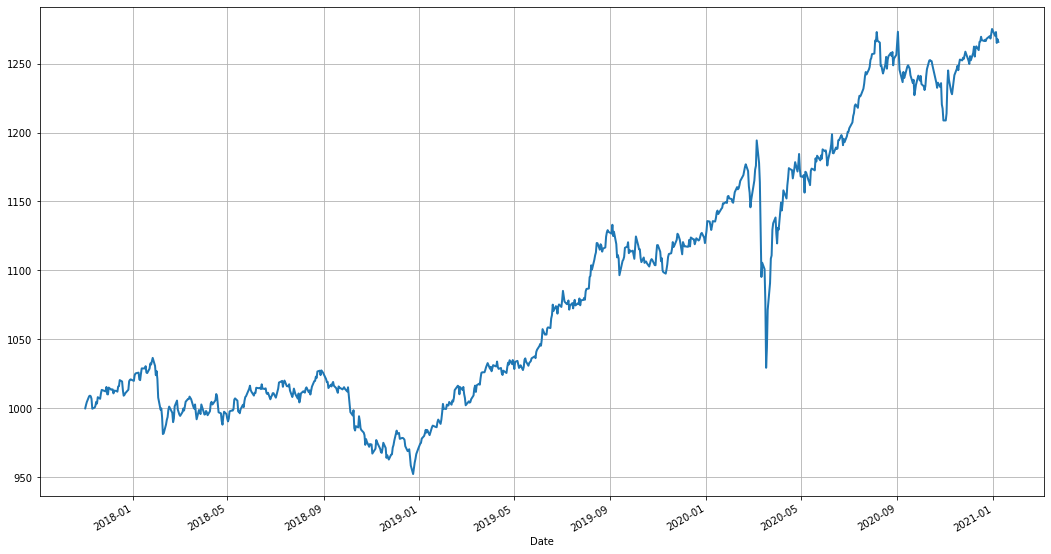

In [3]:
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import pandas as pd
# 차트설정
%matplotlib inline
plt.rc('font', family='NanumSquare')
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams["axes.grid"] = True


#### 개별 종목 함수 만들기
def single_result(first_balance, code, rate, buy_date, end_date):
    single_etf = pd.DataFrame(fdr.DataReader(code, buy_date, end_date)['Close'])

    ## 각 칼럼 생성
    single_etf['Rate'] = 0  # 첫 수익률은 0라 생각하고 시작
    single_etf[code] = first_balance * rate  # 첫 행의 보유 금액 = 처음 자산 * 자산배분비율

    #### 수익률, 평가금액 구하는 법
    for x in range(1, len(single_etf)):
        # 각 행의 수익률 = (현재 가격 - 이전 가격)/이전가격 * 100
        single_etf['Rate'].iloc[x] = ((single_etf['Close'].iloc[x] - single_etf['Close'].iloc[x - 1]) /
                                      single_etf['Close'].iloc[x - 1]) * 100

        # 첫 행의 보유 금액은 자산 배분 비율에 따라 달라짐
        # 평가금액 = 이전 평가금액 * (1+(수익률)/100)
        single_etf[code].iloc[x] = single_etf[code].iloc[x - 1] * (1 + (single_etf['Rate'].iloc[x] / 100))

    return single_etf


#### 포트폴리오(합산) 함수 만들기
def port_result(first_balance, code_list, rate_list, buy_date, end_date):
    ## 포트폴리오 데이터프레임의 인덱스, 칼럼 생성
    multi_df = pd.DataFrame(
        index=fdr.DataReader(str(code_list[0]), buy_date, end_date).index)  # 빈 프레임값의 인덱스를 미리 0번째 etf의 인덱스로 지정
    multi_df['Sum'] = 0  # 첫 행 임의 지정

    ## 포트폴리오의 모든 종목 돌려서 투자 비율 반영된 각 종목 Balance 값 만들기
    for x in range(0, len(code_list)):
        code_name = code_list[x]  # 각 코드명 = 각 코드 리스트 자리 값
        each_rate = rate_list[x]  # 각 비율 = 각 비율 리스트 자리 값
        single_df = single_result(first_balance, code_name, each_rate, buy_date, end_date)

        single_balance_df = pd.DataFrame(single_df[code_name])  # 위의 칼럼만 데이터프레임화 해서 가져올 것
        multi_df = pd.merge(multi_df, single_balance_df, left_index=True, right_index=True,
                            how='left')  # 인덱스 값이 같다면 이어서 Merge 합치기

    ## 포트폴리오 모든 종목의 합산 값 구하기
    for y in range(0, len(multi_df)):
        multi_df['Sum'].iloc[y] = sum(multi_df.iloc[y])

    multi_df = multi_df.dropna(axis=0)

    #### 리밸런싱까지 완료된 후에 각 행의 수익률/CAGR/DD/MDD/Sharp Ratio 구하기

    return multi_df


#### Rate/CAGR/DD/MDD 구하는 함수
def var_result(result_df):
    result_df['Sum_Rate'] = 0  # 합산 금액의 수익률
    result_df['Sum_CAGR'] = 0  # 합산 금액의 평균 복리
    result_df['Sum_DD'] = 0  # 합산 금액의 Draw Down
    result_df['Sum_MDD'] = 0  # 합산 금액의 Max Draw Down

    for z in range(1, len(result_df)):

        # 각 행의 수익률 = (현재 가격 - 이전 가격)/이전가격 * 100
        result_df['Sum_Rate'].iloc[z] = ((result_df['Sum'].iloc[z] - result_df['Sum'].iloc[z - 1]) /
                                         result_df['Sum'].iloc[z - 1]) * 100

        # CAGR 구하기
        if (int(result_df.index[z].year)) == (int(result_df.index[0].year)):  # 1년차의 경우 수익률 값과 동일하게 진행
            result_df['Sum_CAGR'].iloc[z] = result_df['Sum_Rate'].iloc[z]

        # CAGR 공식 = [마지막년도 수치 / 첫년도 수치] ^[1/n] - 1
        else:
            result_df['Sum_CAGR'].iloc[z] = ((result_df['Sum'].iloc[z] / result_df['Sum'].iloc[0]) ** (
                        1 / (result_df.index[z].year - result_df.index[0].year)) - 1) * 100

        # 각 행의 DD = (1- 현재가/현재까지의가격중 최대가) * 100
        result_df['Sum_DD'].iloc[z] = (1 - (result_df['Sum'].iloc[z] / result_df['Sum'].iloc[:z].max())) * 100

        # MDD = 여태까지의 DD중 가장 큰 값
        result_df['Sum_MDD'].iloc[z] = result_df['Sum_DD'].iloc[:z].max()

    return result_df


#### 리밸런싱 함수 만들기
def rebalance(first_balance_, code_list_, rate_list_, buy_date, end_date):
    code_list = code_list_  # 포트폴리오 리스트
    rate_list = rate_list_  # 비율 리스트
    first_balance = first_balance_  # 첫 금액
    start_date = buy_date  # 구매일
    end_date = end_date  # 매도일
    start_year = datetime.strptime(start_date, "%Y-%m-%d").year  # 구매 년도 계산 -> 문자열을 시계열로
    end_year = datetime.strptime(end_date, "%Y-%m-%d").year  # 매도 년도 계산 -> 문자열을 시계열로

    # 1) 매도와 매수 차이가 1년보다 작을 경우 -> 그대로 포트폴리오 합산 함수 사용
    if (end_year - start_year) < 1:
        merged_df = port_result(first_balance, code_list, rate_list, start_date, end_date)

    # 2) 매도와 매수 차이가 1년보다 클 경우 -> 매년 1년 차마다 리밸런싱
    else:
        merged_df = port_result(first_balance, code_list, rate_list, start_date,
                                datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=364))  # 1년차 먼저 계산

        # 2-1) 합친 데이터프레임의 시계열 가장 마지막 날짜가 매도일자보다 작을 경우
        if merged_df.index[-1] < \
                fdr.DataReader(code_list[0], datetime.strptime(end_date, "%Y-%m-%d") - timedelta(7), end_date).index[
                    -1]:
            for year_gap in range(1, int(end_year - start_year)):  # 연차마다 돌려주기

                balance = merged_df['Sum'].iloc[-1]  # 첫 Balance 금액 = 이미 합친 마지막 Balance 값
                year = timedelta(days=365 * year_gap)  # 변수 = 더 해줄 리밸런싱 차이
                start = datetime.strptime(start_date, "%Y-%m-%d") + year  # 매수일자 = 매수 일자 + 리밸런싱 차이 값(1년, 2년, 3년...)
                last = start + timedelta(days=364)  # 매도 일자 = 매수일자 + 364

                start_day = str(start)  # 매수 일자 시계열 값 -> 문자열 값
                # 2-1-1) 매도 일자가 최종 매도일보다 작은 경우 -> 그대로 매도 일자 지정
                if last < datetime.strptime(end_date, "%Y-%m-%d"):
                    last_day = str(last)
                # 2-1-2) 매도 일자가 최종 매도일보다 큰 경우 -> 매도 일자 = 최종 매도일
                else:
                    last_day = str(datetime.strptime(end_date, "%Y-%m-%d"))

                first_result = port_result(balance, code_list, rate_list, start_day, last_day)  # 첫 포트폴리오 함수 값
                merged_df = pd.concat([merged_df, first_result])  # 이어 붙여나가기


        # 2-2) 합친 데이터프레임의 시계열 가장 마지막 날짜가 매도일자보다 큰 경우 Pass
        else:
            pass

    final_df = var_result(merged_df)

    return final_df


#### 그래프 나타내는 함수
def show_graph(df, first_balance):  # 최종 결과 함수값과 최초 투자금액 입력
    show_df = pd.DataFrame(df.iloc[-1]).transpose()  # 최종결과 값의 마지막 값만 데이터프레임화
    show_df['First_Balance'] = first_balance  # 최초 금액 입력
    show_df['Sharp_Ratio'] = df['Sum_Rate'].mean() / df['Sum_Rate'].std() * (252 ** 0.5)  # Sharp Ratio 공식 넣어줄 것
    show_df = show_df[
        ['Sum', 'First_Balance', 'Sum_CAGR', 'Sum_MDD', 'Sharp_Ratio']]  # 최종 금액, 최초 투자 금액, CAGR, MDD, 샤프지수

    return df['Sum'].plot(), show_df  # 보유금액의 변동 그래프 값도 내보내기


#### 각 자산군의 상관관계 나타내는 함수
def pearson(df):
    pearson_df = df[code_list_]

    return pearson_df.corr(method='pearson')


#### 테스트
code_list_ = ['VTI', 'TLT', 'IEI', 'DBC', 'GLD'] # 포트폴리오 리스트
rate_list_ = [0.3, 0.4, 0.15, 0.075, 0.075] # 비율 리스트
first_balance_ = 1000
buy_date = '2017-11-01'
end_date = '2021-01-10'

A = rebalance(first_balance_, code_list_, rate_list_, buy_date, end_date)

pearson(A)
show_graph(A, first_balance_)

In [ ]:
import math
import pandas as pd

def BackTrade(sdf, input_won, krw2usd):
    # sdf: stock dataframe
    
    tot_in = input_won
    ret_usd = tot_in/krw2usd
    num_bought = 0
    num_count = 0

    bi = [] # buy index
    bv = [] # buy values
    si = [] # sell index
    sv = [] # sell values
    
    for j in range(len(sdf.Close)):
        if sdf.slow_d.values[j] <= 20: # and sdf.EMA130[j] > 0:
            # 매수 타이밍
            if ret_usd > sdf.Close.values[j]:
                num_count = math.floor(ret_usd / sdf.Close.values[j])
                ret_usd -= (num_count*sdf.Close.values[j])

                bi.append(sdf.Number[j])
                bv.append(sdf.Close.values[j])
                
                num_bought += num_count
                print('Remain:',ret_usd)
                print(sdf.Close.index[j], 'Buy Price:', round(sdf.Close.values[j],2), ', Num:', num_bought)
                
        elif sdf.slow_d.values[j] >= 80: # and sdf.EMA130[j] > 0:
            # 매도 타이밍
            if num_bought != 0:
                si.append(sdf.Number[j])
                sv.append(sdf.Close.values[j])
                
                ret_usd += (num_bought*sd.Close.values[j])
                print(sdf.Close.index[j], 'Sell Price:', round(sdf.Close.values[j],2), ', Num:', num_bought)
                num_bought = 0
                
    Tr = pd.Series({'bi':bi, 'bv':bv, 'si':si, 'sv':sv})
    res = (num_bought*sd.Close.values[len(sd.Close)-1] + ret_usd)*krw2usd

    return Tr, res

In [417]:
rm_data = data[['A293490_RM','A263750_RM','A259960_RM','A251270_RM','A194480_RM','A192080_RM','A181710_RM','A112040_RM','A078340_RM','A036570_RM']]
rm_data


,A293490_RM,A263750_RM,A259960_RM,A251270_RM,A194480_RM,A192080_RM,A181710_RM,A112040_RM,A078340_RM,A036570_RM
2021-08-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-08-11,-0.017252,-0.006787,-0.086129,0.032265,0.021099,0.022188,-0.011524,0.085753,0.001536,-0.013280
2021-08-12,-0.011891,0.005572,0.010404,-0.020106,-0.099070,-0.003037,-0.016919,0.129863,0.000327,0.033114
2021-08-13,0.008379,-0.037396,0.105038,-0.009196,0.025913,0.028683,0.014753,0.059786,-0.012115,0.003869
2021-08-17,0.009407,-0.017599,0.043883,-0.005045,-0.061520,-0.042609,-0.017605,0.209132,-0.034666,-0.008381
...,...,...,...,...,...,...,...,...,...,...
2022-08-04,-0.034655,-0.006750,0.005542,0.005623,0.004938,-0.010162,0.001460,0.214400,-0.002700,-0.024968
2022-08-05,-0.005910,0.012863,-0.016496,0.008607,-0.020980,-0.003857,-0.002504,0.008422,-0.009734,0.009605
2022-08-08,-0.006553,0.020440,0.008373,-0.006899,-0.014365,-0.003719,-0.003078,-0.043889,0.005842,0.001245
2022-08-09,-0.000962,-0.024016,-0.017396,-0.000962,-0.025634,-0.025350,-0.011482,-0.021990,-0.030122,0.031555


In [420]:
month_ret_df = rm_data.rank(axis=1, ascending=False, method='max', pct=True) # 투자종목 선택할 rank
month_ret_df = month_ret_df.where( month_ret_df < 0.4 , np.nan)
month_ret_df.fillna(0,inplace=True)
month_ret_df[month_ret_df != 0] = 1
month_ret_df

,A293490_RM,A263750_RM,A259960_RM,A251270_RM,A194480_RM,A192080_RM,A181710_RM,A112040_RM,A078340_RM,A036570_RM
2021-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-08-11,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2021-08-12,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2021-08-13,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2021-08-17,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-04,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-08-05,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-08-08,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-08-09,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
stock_codes = ['A293490','A263750','A259960','A251270','A194480','A192080','A181710','A112040','A078340','A036570']

# 3단계. signal list로 trading + positioning
sig_dict = dict()
for date in month_ret_df.index:
    ticker_list = list(month_ret_df.loc[date,month_ret_df.loc[date,:] >= 1.0].index)
    sig_dict[date] = ticker_list
stock_c_matrix = stock_df.pivot('date','code','close_price').copy()
book = create_trade_book(stock_c_matrix, list(stock_df['code'].unique()))

for date,values in sig_dict.items():
    for stock in values:
        book.loc[date,'p '+ stock] = 'ready ' + stock
        
# 3-2  tradings
book = tradings(book, stock_codes)

# 4 단게. 수익률 계산하기.
multi_returns(book, stock_codes)

In [397]:
book

,A293490,A263750,A259960,A251270,A194480,A192080,A181710,A112040,A078340,A036570
2021-08-10,0,0,0,0,0,0,0,0,0,0
2021-08-11,0,0,0,1,1,1,0,1,0,0
2021-08-12,0,0,0,0,0,0,0,2,0,1
2021-08-13,0,0,1,0,0,0,0,1,0,0
2021-08-17,0,0,2,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-08-04,0,0,2,2,2,0,1,1,0,0
2022-08-05,0,1,0,1,0,0,0,2,0,1
2022-08-08,0,2,1,0,0,0,0,0,2,2
2022-08-09,0,0,0,0,0,0,0,0,0,1


In [ ]:
trade = pd.DataFrame

In [364]:
book['A293490'][book['A293490'] == 1][0::2]

2021-08-20    1
2021-08-26    1
2021-09-10    1
2021-09-27    1
2021-10-12    1
2021-10-18    1
2021-10-22    1
2021-10-27    1
2021-11-01    1
2021-11-04    1
2021-11-08    1
2021-11-15    1
2021-11-18    1
2021-11-26    1
2021-12-03    1
2021-12-21    1
2021-12-24    1
2021-12-30    1
2022-01-20    1
2022-01-26    1
2022-02-04    1
2022-02-11    1
2022-02-18    1
2022-02-23    1
2022-02-28    1
2022-03-08    1
2022-03-11    1
2022-03-17    1
2022-03-23    1
2022-03-29    1
2022-04-05    1
2022-04-19    1
2022-05-11    1
2022-05-16    1
2022-05-20    1
2022-05-30    1
2022-06-14    1
2022-06-21    1
2022-06-27    1
2022-07-12    1
2022-07-18    1
2022-07-26    1
2022-07-29    1
2022-08-03    1
Name: A293490, dtype: object

In [171]:
data[f'A036570_mean_acc'] = 0.0

In [194]:
data

,A036570,A078340,A112040,A181710,A192080,A194480,A251270,A259960,A263750,A293490,종가,종가_acc,종가_log_acc
date,,,,,,,,,,,,,
2021-08-10,815000,113500,25864,39697,62600,81000,134500,454000,70300,83700,1515.36,0.000000,0.000000
2021-08-11,790000,111700,27632,38549,62900,81300,136500,407000,68600,80800,1489.00,-0.017395,-0.017548
2021-08-12,806000,110300,30865,37401,61900,72200,132000,406000,68100,78800,1469.85,-0.030032,-0.030493
2021-08-13,786000,105800,31825,36880,61900,72000,127000,437000,63600,77200,1427.69,-0.057854,-0.059595
2021-08-17,771000,101000,38140,35836,58600,66800,125000,451500,61800,77100,1412.41,-0.067938,-0.070356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,385500,84800,74900,28900,42300,47250,71600,263000,59200,58100,887.50,-0.414331,-0.535000
2022-08-05,387500,83600,75200,28700,41950,46050,71900,257500,59700,57500,883.58,-0.416917,-0.539426
2022-08-08,388500,84200,72000,28650,41850,45450,71500,260000,61000,57200,884.76,-0.416139,-0.538092


In [172]:
data[f'A036570_mean_acc'][1] = data[f'A036570_acc'][1] - data['종가_acc'][1]

/tmp/ipykernel_273/903297048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'A036570_mean_acc'][1] = data[f'A036570_acc'][1] - data['종가_acc'][1]


In [71]:
data[f'A036570_acc'].iloc[1] - data['종가_acc'].iloc[1]

-0.01327964020617034

In [66]:
data[f'A036570_mean_acc']

KeyError: 'A036570_mean_acc'

In [ ]:
#종목 데이터 읽어오기.
data = pd.read_csv('./data_sma.csv', index_col = 0)
data.fillna(0,inplace=True)

# 필요한 데이터 프레임 생성
# Monthly 데이터를 저장하기 위함이다.
day_last_df = pd.DataFrame(columns=['date','code','1D_RET'])

# 종목 데이터 프레임 생성
stock_df = pd.DataFrame(columns =['date','code','close_price'])

#read_df = day_data

code_list = ['A259960','A036570','A251270','A293490','A263750','A078340','A181710','A192080','A194480','A112040']


for code in code_list:
    data[f'acc_{code}'] = data[code].pct_change().fillna(0)

In [2]:
data  = pd.read_csv('./total.csv')
data['sma5'] = data['종가'].rolling(5).mean()
data['sma20'] = data['종가'].rolling(20).mean()
data['sma100'] = data['종가'].rolling(100).mean()
data['sma200'] = data['종가'].rolling(200).mean()


In [63]:
data  = pd.read_csv('./data_sma.csv', index_col = 0)
data.fillna(0,inplace=True)

In [15]:
data[['A036570','종가']].pct_change()

,A036570,종가
0,NaN,NaN
1,-0.013850,-0.023939
2,0.081461,0.039099
3,-0.037662,-0.033372
4,0.002699,0.009899
...,...,...
981,0.013141,0.038109
982,0.005188,-0.004417
983,0.002581,0.001335
984,0.060489,0.028934


In [12]:
data

,date,A036570,A078340,A112040,A181710,A192080,A194480,A251270,A259960,A263750,...,시가,고가,저가,거래량,거래대금,상장시가총액,sma5,sma20,sma100,sma200
0,2018-08-10,361000,142000,18918,34011,64700,14500,127000,0.0,47520,...,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.0000,0.0000,0.00000
1,2018-08-13,356000,137600,15711,32602,64400,14350,122500,0.0,47380,...,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.0000,0.0000,0.00000
2,2018-08-14,385000,143300,15736,32081,67200,14350,123500,0.0,49280,...,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.0000,0.0000,0.00000
3,2018-08-16,370500,142700,16115,31716,66400,14300,116000,0.0,47560,...,0.00,0.00,0.00,0.0,0.0,0.0,0.000,0.0000,0.0000,0.00000
4,2018-08-17,371500,142100,16039,32081,66400,14300,119000,0.0,48100,...,0.00,0.00,0.00,0.0,0.0,0.0,924.226,0.0000,0.0000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,2022-08-04,385500,84800,74900,28900,42300,47250,71600,263000.0,59200,...,866.04,891.90,865.10,11385.0,844579.0,41900000.0,844.534,832.9245,958.5790,1171.39950
982,2022-08-05,387500,83600,75200,28700,41950,46050,71900,257500.0,59700,...,890.61,896.06,877.80,5189.0,399978.0,41700000.0,855.232,836.0470,956.3719,1168.80320
983,2022-08-08,388500,84200,72000,28650,41850,45450,71500,260000.0,61000,...,876.79,886.85,870.80,2500.0,193538.0,41700000.0,865.736,839.5935,954.0741,1165.93625
984,2022-08-09,412000,84100,72500,29150,42000,45600,73500,263000.0,61300,...,884.91,914.54,882.33,4332.0,393734.0,42800000.0,884.224,844.9400,951.7319,1163.28580


In [18]:
import os 
import glob
from data.lds.lds_handler import LocalDataStorage as lds
from datetime import datetime
import pandas as pd
import numpy as np
from momentum_handler import Momentum as mom

startTime_string = '2018-08-10'
endTime_string = '2022-08-10'
datetime_format = '%Y-%m-%d'

#종목 데이터 읽어오기.
data = pd.read_csv('./data_sma.csv', index_col = 0)
data.fillna(0,inplace=True)

# 필요한 데이터 프레임 생성
# Monthly 데이터를 저장하기 위함이다.
day_last_df = pd.DataFrame(columns=['date','code','1D_RET'])

# 종목 데이터 프레임 생성
stock_df = pd.DataFrame(columns =['date','code','close_price'])

#read_df = day_data

code_list = ['A259960','A036570','A251270','A293490','A263750','A078340','A181710','A192080','A194480','A112040']


for code in code_list:
    data[f'D_RTN_{code}'] = data[code].pct_change().fillna(0)



In [20]:
data.to_csv('test.csv', encoding='utf-8-sig')

In [ ]:
data = pd.

In [26]:
new_data = data[['date','D_RTN_A259960','D_RTN_A036570','D_RTN_A251270','D_RTN_A293490','D_RTN_A263750','D_RTN_A078340','D_RTN_A181710','D_RTN_A192080','D_RTN_A194480','D_RTN_A112040',
    'sma5','sma20','sma100','sma200']]


In [76]:
new_data

,date,D_RTN_A259960,D_RTN_A036570,D_RTN_A251270,D_RTN_A293490,D_RTN_A263750,D_RTN_A078340,D_RTN_A181710,D_RTN_A192080,D_RTN_A194480,D_RTN_A112040,sma5,sma20,sma100,sma200
739,2021-08-10,0.000000,-0.008516,-0.003704,0.013317,0.001425,-0.018166,-0.014229,-0.001595,-0.081633,0.009839,1520.626,1574.0080,1417.8545,1366.34390
740,2021-08-11,-0.103524,-0.030675,0.014870,-0.034648,-0.024182,-0.015859,-0.028919,0.004792,0.003704,0.068358,1513.898,1572.5170,1419.2004,1368.00545
741,2021-08-12,-0.002457,0.020253,-0.032967,-0.024752,-0.007289,-0.012534,-0.029780,-0.015898,-0.111931,0.117002,1501.786,1569.1660,1420.3401,1369.65760
742,2021-08-13,0.076355,-0.024814,-0.037879,-0.020305,-0.066079,-0.040798,-0.013930,0.000000,-0.002770,0.031103,1483.504,1561.0075,1420.9868,1371.09290
743,2021-08-17,0.033181,-0.019084,-0.015748,-0.001295,-0.028302,-0.045369,-0.028308,-0.053312,-0.072222,0.198429,1462.862,1553.2125,1421.5564,1372.33075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,2022-08-04,0.043651,0.013141,0.043732,0.003454,0.031359,0.035409,0.039568,0.027947,0.043046,0.252508,844.534,832.9245,958.5790,1171.39950
982,2022-08-05,-0.020913,0.005188,0.004190,-0.010327,0.008446,-0.014151,-0.006920,-0.008274,-0.025397,0.004005,855.232,836.0470,956.3719,1168.80320
983,2022-08-08,0.009709,0.002581,-0.005563,-0.005217,0.021776,0.007177,-0.001742,-0.002384,-0.013029,-0.042553,865.736,839.5935,954.0741,1165.93625
984,2022-08-09,0.011538,0.060489,0.027972,0.027972,0.004918,-0.001188,0.017452,0.003584,0.003300,0.006944,884.224,844.9400,951.7319,1163.28580


In [77]:
aaa = 1+new_data['D_RTN_A259960'].cumprod()-1
aaa

739    0.0
740    0.0
741    0.0
742    0.0
743    0.0
      ... 
981    0.0
982    0.0
983    0.0
984    0.0
985    0.0
Name: D_RTN_A259960, Length: 247, dtype: float64

In [64]:
data = pd.read_csv('./test.csv', index_col = 0, encoding='CP949')


In [80]:
new_data = data[['date','A259960','A036570','A251270','A293490','A263750','A078340','A181710','A192080','A194480','A112040', '종가']]

In [82]:
new_data.set_index('date',inplace=True)

In [83]:
new_data

,A259960,A036570,A251270,A293490,A263750,A078340,A181710,A192080,A194480,A112040,종가
date,,,,,,,,,,,
2021-08-10,454000,815000,134500,83700,70300,113500,39697,62600,81000,25864,1515.36
2021-08-11,407000,790000,136500,80800,68600,111700,38549,62900,81300,27632,1489.00
2021-08-12,406000,806000,132000,78800,68100,110300,37401,61900,72200,30865,1469.85
2021-08-13,437000,786000,127000,77200,63600,105800,36880,61900,72000,31825,1427.69
2021-08-17,451500,771000,125000,77100,61800,101000,35836,58600,66800,38140,1412.41
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,263000,385500,71600,58100,59200,84800,28900,42300,47250,74900,887.50
2022-08-05,257500,387500,71900,57500,59700,83600,28700,41950,46050,75200,883.58
2022-08-08,260000,388500,71500,57200,61000,84200,28650,41850,45450,72000,884.76


In [84]:
col_list_P = [col+'_P' for col in new_data.columns]
col_list_PA = [col+'_PA' for col in new_data.columns]
col_list_LPA = [col+'_LPA' for col in new_data.columns]

In [87]:
# 각 자산별 수익률 계산
col_list_P = [col+'_P' for col in new_data.columns]
col_list_PA = [col+'_PA' for col in new_data.columns]
col_list_LP = [col+'_LP' for col in new_data.columns]
col_list_LPA = [col+'_LPA' for col in new_data.columns]

new_data[col_list_P] = new_data.pct_change()
new_data[col_list_PA] = (1+new_data[col_list_P]).cumprod()-1
new_data[col_list_LP] = np.log(new_data[col_list_P]+1)
new_data[col_list_LPA] = new_data[col_list_LP].cumsum()

# 백분율을 %로 전환
new_data[col_list_P+col_list_PA+col_list_LP+col_list_LPA] = new_data[col_list_P+col_list_PA+col_list_LP+col_list_LPA] * 100


/tmp/ipykernel_10124/2507636168.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10124/2507636168.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10124/2507636168.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1

In [88]:
new_data

,A259960,A036570,A251270,A293490,A263750,A078340,A181710,A192080,A194480,A112040,...,A036570_LPA,A251270_LPA,A293490_LPA,A263750_LPA,A078340_LPA,A181710_LPA,A192080_LPA,A194480_LPA,A112040_LPA,종가_LPA
date,,,,,,,,,,,,,,,,,,,,,
2021-08-10,454000,815000,134500,83700,70300,113500,39697,62600,81000,25864,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-11,407000,790000,136500,80800,68600,111700,38549,62900,81300,27632,...,-3.115517,1.476042,-3.526201,-2.447926,-1.598613,-2.934546,0.478089,0.369686,6.612248,-1.754828
2021-08-12,406000,806000,132000,78800,68100,110300,37401,61900,72200,30865,...,-1.110437,-1.876228,-6.032598,-3.179459,-2.859891,-5.957818,-1.124510,-11.500911,17.677082,-3.049268
2021-08-13,437000,786000,127000,77200,63600,105800,36880,61900,72000,31825,...,-3.623132,-5.737711,-8.083952,-10.015833,-7.025232,-7.360622,-1.124510,-11.778304,20.740010,-5.959528
2021-08-17,451500,771000,125000,77100,61800,101000,35836,58600,66800,38140,...,-5.549974,-7.325046,-8.213570,-12.886843,-11.668232,-10.232264,-6.603058,-19.274607,38.841156,-7.035557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-04,263000,385500,71600,58100,59200,84800,28900,42300,47250,74900,...,-74.864692,-63.046913,-36.507331,-17.185026,-29.150729,-31.743402,-39.197819,-53.899650,106.330185,-53.499979
2022-08-05,257500,387500,71900,57500,59700,83600,28700,41950,46050,75200,...,-74.347226,-62.628793,-37.545403,-16.343978,-30.575932,-32.437850,-40.028685,-56.472139,106.729919,-53.942648
2022-08-08,260000,388500,71500,57200,61000,84200,28650,41850,45450,72000,...,-74.089494,-63.186675,-38.068508,-14.189793,-29.860792,-32.612217,-40.267348,-57.783633,102.381408,-53.809189


In [75]:
import plotly.graph_objects as go
import numpy as np


# labels = ['D_RTN_A259960','D_RTN_A036570','D_RTN_A251270','D_RTN_A293490','D_RTN_A263750','D_RTN_A078340','D_RTN_A181710','D_RTN_A192080','D_RTN_A194480','D_RTN_A112040',
#     'sma5','sma20','sma100','sma200']
labels = ['D_RTN_A259960','D_RTN_A036570','D_RTN_A251270','D_RTN_A293490','D_RTN_A263750','D_RTN_A078340','D_RTN_A181710','D_RTN_A192080','D_RTN_A194480','D_RTN_A112040',
'sma5','sma20','sma100','sma200']


fig = go.Figure()
for i in range(0,len(labels)):
    fig.add_scatter(name=labels[i])


for i in range(0,len(labels)):
    fig.data[i].x = new_data['date']
    fig.data[i].y = new_data[labels[i]]

fig



In [59]:
labels[0]

'D_RTN_A259960'

In [51]:
fig.data[0].y = new_data['sma200']


In [90]:
data = pd.read_csv('./mom_data.csv', encoding='CP949')

In [94]:
data.query('Sales == 300')

,date,A036570,A078340,A112040,A181710,A192080,A194480,A251270,A259960,A263750,...,RM_A036570,RM_A078340,RM_A112040,RM_A181710,RM_A192080,RM_A194480,RM_A251270,RM_A259960,RM_A263750,RM_A293490
0,2021-08-10,815000,113500,25864,39697,62600,81000,134500,454000,70300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-08-11,790000,111700,27632,38549,62900,81300,136500,407000,68600,...,-0.013280,0.001536,0.085753,-0.011524,0.022188,0.021099,0.032265,-0.086129,-0.006787,-0.017252
2,2021-08-12,806000,110300,30865,37401,61900,72200,132000,406000,68100,...,0.033114,0.000327,0.129863,-0.016919,-0.003037,-0.099070,-0.020106,0.010404,0.005572,-0.011891
3,2021-08-13,786000,105800,31825,36880,61900,72000,127000,437000,63600,...,0.003869,-0.012115,0.059786,0.014753,0.028683,0.025913,-0.009196,0.105038,-0.037396,0.008379
4,2021-08-17,771000,101000,38140,35836,58600,66800,125000,451500,61800,...,-0.008381,-0.034666,0.209132,-0.017605,-0.042609,-0.061520,-0.005045,0.043883,-0.017599,0.009407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2022-08-04,385500,84800,74900,28900,42300,47250,71600,263000,59200,...,-0.024968,-0.002700,0.214400,0.001460,-0.010162,0.004938,0.005623,0.005542,-0.006750,-0.034655
243,2022-08-05,387500,83600,75200,28700,41950,46050,71900,257500,59700,...,0.009605,-0.009734,0.008422,-0.002504,-0.003857,-0.020980,0.008607,-0.016496,0.012863,-0.005910
244,2022-08-08,388500,84200,72000,28650,41850,45450,71500,260000,61000,...,0.001245,0.005842,-0.043889,-0.003078,-0.003719,-0.014365,-0.006899,0.008373,0.020440,-0.006553
245,2022-08-09,412000,84100,72500,29150,42000,45600,73500,263000,61300,...,0.031555,-0.030122,-0.021990,-0.011482,-0.025350,-0.025634,-0.000962,-0.017396,-0.024016,-0.000962
